<a href="https://colab.research.google.com/github/hyunku/Reservoir-Computing/blob/main/minimalESN_torch_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# -*- coding: utf-8 -*-
"""
A minimalistic Echo State Networks demo with Mackey-Glass (delay 17) data 
in "plain" scientific Python.
from https://mantas.info/code/simple_esn/
(c) 2012-2020 Mantas Lukoševičius
Distributed under MIT license https://opensource.org/licenses/MIT
"""
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy import linalg
import sys
# numpy.linalg is also an option for even fewer dependencies

In [ ]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 100
data = torch.tensor(np.loadtxt('/content/gdrive/MyDrive/ReservoirComputing/MackeyGlass_t17.txt'), dtype=float)
print(data.shape)

torch.Size([10000])


Text(0.5, 1.0, 'A sample of data')

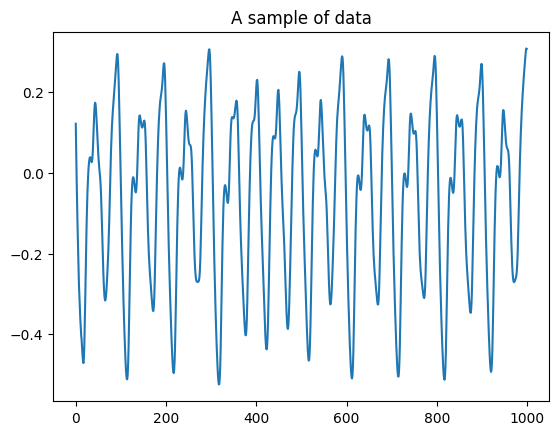

In [ ]:
# plot some of it
plt.figure(10).clear()
plt.plot(data[:1000])
plt.title('A sample of data')

In [ ]:
# generate the ESN reservoir
inSize = outSize = 1
resSize = 1000
a = 0.3 # leaking rate, reservoir 뉴런 값 수정률
np.random.seed(42)
torch.manual_seed(0)
Win = (torch.rand(resSize,1+inSize) - 0.5) * 1 # (1000, 2) 행렬 생성 -> (reservoir수, 인풋차원+1) , Weight_In : 인풋 뉴런의 가중치 행렬
W = torch.rand(resSize,resSize) - 0.5 # (1000, 1000) 초기 가중치 행렬 생성(랜덤) -> (reservoir수, reservoir수) : reservoir 뉴런의 학습 가중치 행렬

In [ ]:
# normalizing and setting spectral radius (correct, slow):
print('Computing spectral radius...')
# rhoW = spectral radius
rhoW = max(abs(torch.linalg.eig(W)[0])) # 가중치 행렬에서 고유값 추출 (각 뉴런 업데이트시 W에 곱해지는 강도(spectral radius)), W 행렬 1개당 1개 값 생성됌
# reservoir 뉴런 개수인 resSize 가 90이라면 90 * 90 차원의 랜덤 행렬 생성후 고유값은 90개가 나옴.
print('done.')
# 가중치 업데이트 과정 -> 각 고유값을 weight_scaling 값으로 나눈 값으로 가중치를 업데이트함. -> weight_scaling은 가중치 학습률이다.
W *= 1.25 / rhoW

Computing spectral radius...
done.


In [ ]:
# allocated memory for the design (collected states) matrix
# X의 형태에서 row인 1002는 1회 학습시 업데이트될 인풋값(1회 학습하여 업데이트 된 X값은 세로방향으로 들어옴), 1900 col은 기록할 학습 횟수(총 학습 횟수 - 최소초기학습횟수) 
X = torch.zeros((1+inSize+resSize,trainLen-initLen), dtype=float) # (1002, 1900) 학습 데이터 행렬 초기 정의
# set the corresponding target matrix directly
Yt = data[None,initLen+1:trainLen+1]  # (1, 1900) -> 예측 데이터는 101번부터 2001번 index, Yt는 Y truth로 실제값

In [ ]:
# run the reservoir with the data and collect X
x = torch.zeros((resSize,1)) # (1000,1) , reservoir 뉴런이 갖고있는 값
for t in range(trainLen): # train data 2000개만큼 돌면서(reservoir 뉴런의 학습 횟수)
    u = data[t] # u에 t번째 데이터 할당 
    # print(np.vstack((1,u)))
    # print(np.dot(Win, np.vstack((1,u))).shape) # (1000,2) 내적 (2,1) -> (1000,1) -> 인풋뉴런에 인풋 데이터 주입
    # print("###")
    # print(np.dot(W,x).shape) # (1000,1000) 내적 (1000,1) -> (1000,1) -> 뉴런 내부값에 가중치 매트릭스 곱해서 업데이트
    # print("###")

    # vstack : 위아래 결합, hstack : 좌우결합
    # reservoir 뉴런 내부값 업데이트 과정, 활성함수 tanh사용
    x = (1-a)*x + a*torch.tanh( torch.matmul( Win, torch.tensor((1, u), dtype=torch.float).reshape(-1, 1) ) + torch.matmul( W, x ) ) # (1000,1)
    # print(np.vstack((1,u,x)).shape) # (1002,1) 세로로된 리스트
    # print(np.vstack((1,u,x))[:,0].shape) # (1002,) 가로로된 리스트
    
    # 학습횟수(2000번) 중에 최소초기학습횟수 넘어갈 때부터 학습데이터도 업데이트
    if t >= initLen: # 최소초기학습횟수 넘어갈때부터 학습 데이터 업데이트(최소초기학습 횟수 이전까지는 reservoir 뉴런값, Weight matrix만 업데이트)
        X[:,t-initLen] = torch.concat((torch.tensor([[1]]),torch.tensor([[u]]),x), axis=0)[:,0]

In [ ]:
# print(np.dot(X, X.T).shape) # (1002,1002) -> 업데이트된 인풋행렬(X) 에서 각 요소 제곱하여 음수값 제거
# print(np.eye(1+inSize+resSize)) # (1002,1002) 의 대각행렬 생성(대각선만 1, 나머지 0) ->  행렬곱 진행 시 regularization 진행을 위한 행렬
# print((np.dot(X,X.T) + np.eye(1+inSize+resSize)).shape) # (1002,1002) -> 제곱하여 음수값 제거한 인풋 행렬에 규제수치 곱해줌 -> 규제화한 예측값 행렬
# print(np.dot(X,Yt.T).shape) # (1002,1) -> 업데이트된 인풋 행렬(X, (1002,1900))과 예측값행렬(Yt.T(1900,1)) 의 내적 -> 학습 횟수당 실제값 행렬(ground truth)

# train the output by ridge regression
reg = 1e-8  # regularization coefficient
# direct equations from texts:
#X_T = X.T
#Wout = np.dot( np.dot(Yt,X_T), linalg.inv( np.dot(X,X_T) + \
#    reg*np.eye(1+inSize+resSize) ) )
# using scipy.linalg.solve:
# 연립방정식에서 규제화한 예측값 행렬을 계수로 사용하고 학습 횟수당 실제값행렬을 실제값으로 사용하여 연립방정식의 해를 구함
# 이때, 연립방정식의 해는 예측값에서 얼만큼의 가중치를 곱해줘야 실제값이 나오는지에서 가중치의 값을 의미함.
mat_a = torch.matmul(X,X.T) + reg*torch.eye(1+inSize+resSize)
mat_b = torch.matmul(X,Yt.T)
Wout = torch.matmul(torch.linalg.inv(mat_a), mat_b).T # (1,1002)

In [ ]:
# run the trained ESN in a generative mode. no need to initialize here, 
# because x is initialized with training data and we continue from there.
Y = torch.zeros((outSize,testLen)) # (1,2000)
u = data[trainLen] # 학습에 사용한 데이터셋의 마지막 인덱스의 값

In [ ]:
for t in range(testLen): # 테스트 사이즈 2000번 돌면서
    x = (1-a)*x + a*torch.tanh( torch.matmul( Win, torch.tensor((1,u), dtype=torch.float).reshape(-1, 1) ) + torch.matmul( W, x ) ) # 학습된 reservoir 뉴런들의 가중치
    y = torch.matmul( Wout, torch.cat([torch.tensor([[1]], dtype=float), u.reshape(-1, 1), x], dim=0) ) # (1,1002) 내적 (1002,1) -> 출력층으로 가는 weight값과 학습된 reservoir들의 가중치 내적(연결) -> 예측값 도출
    Y[:,t] = y # 테스트셋의 인덱스 때마다 나온 결과 입력
    # generative mode: # 테스트 모드
    u = y # 예측값을 다음 테스트의 인풋으로 넣음
    ## this would be a predictive mode: # 예측 모드 -> 둘중 하나 아무거나 사용해도 무방해보임
    #u = data[trainLen+t+1] 

In [ ]:
# compute MSE for the first errorLen time steps
errorLen = 500
mse = sum( torch.square( data[trainLen+1:trainLen+errorLen+1] - 
    Y[0,0:errorLen] ) ) / errorLen
print('MSE = ' + str( mse ))

MSE = tensor(5.3065e-06, dtype=torch.float64)


C:\Users\jyb\AppData\Local\Temp\ipykernel_13956\3724845391.py:14: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3281.)
  plt.bar( np.arange(1+inSize+resSize), Wout[0].T )


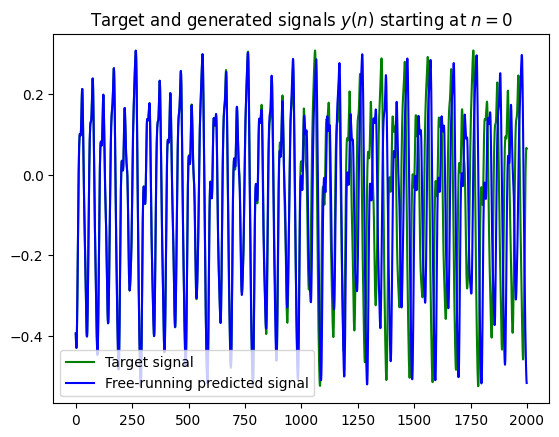

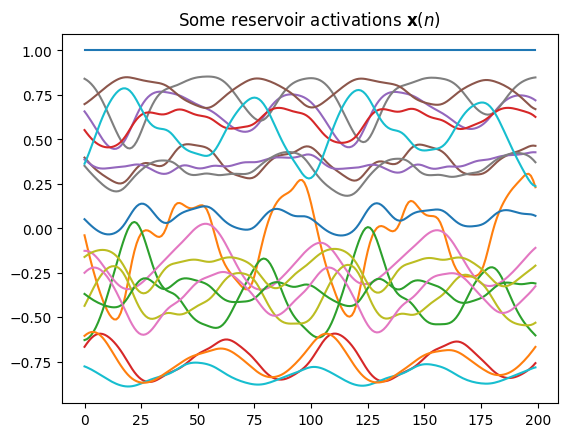

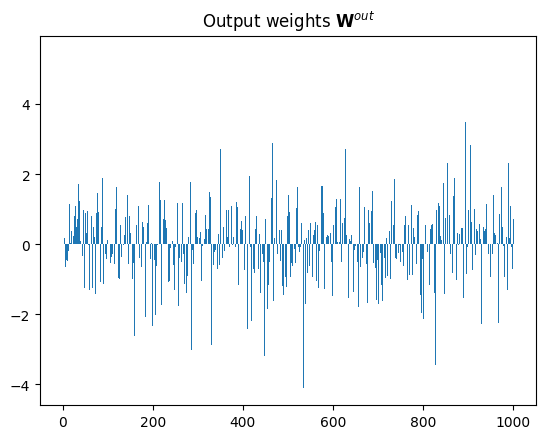

In [ ]:
# plot some signals
plt.figure(1).clear()
plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
plt.plot( Y.T, 'b' )
plt.title('Target and generated signals $y(n)$ starting at $n=0$')
plt.legend(['Target signal', 'Free-running predicted signal'])


plt.figure(2).clear()
plt.plot( X[0:20,0:200].T )
plt.title(r'Some reservoir activations $\mathbf{x}(n)$')

plt.figure(3).clear()
plt.bar( np.arange(1+inSize+resSize), Wout[0].T )
plt.title(r'Output weights $\mathbf{W}^{out}$')

plt.show()